In [1]:
import warnings

import torch
from cifar_utils import (
    fhe_compatibility,
    fhe_simulation_inference,
    get_dataloader,
    plot_dataset,
    torch_inference
)
from models import QuantVGG11
from torchvision import datasets

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
bit = 5
seed = 42

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device Type: {device}")

Device Type: cpu


## CIFAR-10 with FHE simulation

In [3]:
param_c10 = {
    "output_size": 10,
    "batch_size": 128,
    "dataset_name": "CIFAR_10",
    "dataset": datasets.CIFAR10,
    "std": [0.247, 0.243, 0.261],
    "mean": [0.4914, 0.4822, 0.4465],
    "dir": "./checkpoints/CIFAR_10",
    "pre_trained_path": "quant/CIFAR_10_quant_state_dict.pt",
    "seed": 42,
}

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


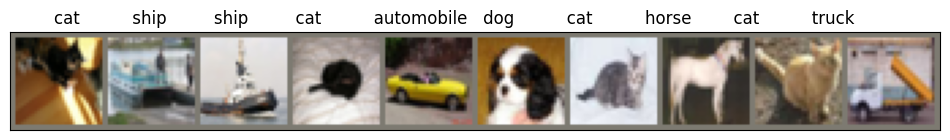

In [4]:
# Load CIFAR-10 data-set.
train_loader_c10, test_loader_c10 = get_dataloader(param=param_c10)

# Let’s visualize `n` images from CIFAR-10 data-set.
plot_dataset(test_loader_c10, param_c10)

In [6]:
quant_vgg_c10 = QuantVGG11(bit=bit, output_size=param_c10["output_size"])

checkpoint = torch.load(f"{param_c10['dir']}/{param_c10['pre_trained_path']}", map_location=device)

quant_vgg_c10.load_state_dict(checkpoint)

<All keys matched successfully>

In [7]:
data_calibration, _ = next(iter(train_loader_c10))

qmodel_c10 = fhe_compatibility(quant_vgg_c10, data_calibration)

print(
    f"Maximum bit-width in the circuit: {qmodel_c10.fhe_circuit.graph.maximum_integer_bit_width()}"
)

Maximum bit-width in the circuit: 14


In [9]:
acc_torch_c10 = torch_inference(quant_vgg_c10, test_loader_c10, device=device)

In [8]:
acc_fhe_c10 = fhe_simulation_inference(qmodel_c10, test_loader_c10, True)

100%|██████████| 78/78 [1:13:45<00:00, 56.73s/it]


In [11]:
print(f"Top-1 acc in Brevitas torch : {acc_torch_c10 * 100 :2.2f}%")
print(f"Top-1 acc with Concrete ML  : {acc_fhe_c10 * 100 :2.2f}%")

Top-1 acc in Brevitas torch : 89.21%
Top-1 acc with Concrete ML  : 89.19%
